Simulate a 25 year time series of ibex population dynamics and associated observations using the following parameter values:
- An initial population size of 50
- A long-term growth rate of 1.02
- A variance of the normal random effect distribution of 0.02
- A variance of the observation process of 20

In [1]:
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


In [2]:
N0 = 30
years = 25
# 25 years of data
mu0 = 1.02
sigma0 = 0.02
sigma = 20
N = numeric(25)
y = numeric(25)
N[1] = N0
lambda <- numeric(years-1)

for(t in 1:(years - 1)) {
    lambda[t] = rnorm(1, mu0, sqrt(sigma0))
    N[t+1] = lambda[t] * N[t]
}

for(t in 1:years) {
    y[t] = rnorm(1, N[t], sqrt(sigma))
}

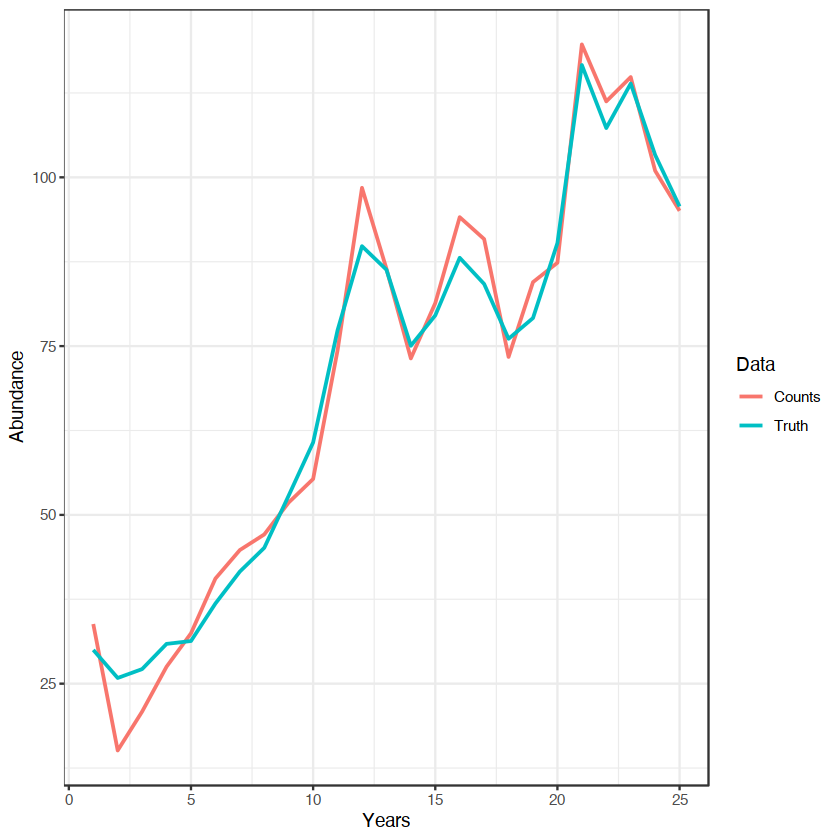

In [3]:
ibex <- data.frame(Values = c(y,N),
                   Data = rep(c("Counts","Truth"),
                              each=years),
                   Years = rep(1:years,2))
ggplot(data=ibex, aes(x=Years, y=Values, group=Data, color=Data)) +
geom_line(size=0.8) + theme_bw() + ylab("Abundance")

In [4]:
library(statsecol)
library(jagsUI)
library(ggplot2)

Warning message:
“package ‘jagsUI’ was built under R version 4.1.1”


While we have generated the population trajectories, in practice we only have the counts which we use to estimate parameters of a population dynamics model and the latent population states. We are going to do that using a Bayesian analysis in JAGS following these analysis steps:

- Write a model file in BUGS language
- Collect and package data
- Set initial values
- Specify parameters to monitor
- Define MCMC settings
- Sample from the posterior using MCMC (i.e., fit the model)


$$\mu_{\lambda} \sim Unif(0, 100)$$
$$\sigma_{\lambda} \sim Unif(0, 10)$$
$$\sigma_{y} \sim Unif(0, 100)$$
$$N_{1} \sim Unif(0, 500)$$


With the likelihood and the defined, the next task is to translate this into the BUGS language. Below is a skeleton for a BUGS model description for the ibex data. Note that the sink() and cat() functions are R code for creating, writing and saving the model description as a text file in your working directory. See if you can fill complete the model:

In [5]:
sink("ibexSSM.txt")
cat("
model{
  # Priors and constraints
  
  mu0 ~ dunif(0, 100)
  sigma0 ~ dunif(0, 10)
  sigma ~ dunif(0, 100)
  N1 ~ dunif(0, 500)
  
  N[1] = N1

  sigma0_prec = 1/(sigma0^2)
  sigma_prec = 1/(sigma^2)


  # Likelihood - State process
  for (t in 1:(nyrs-1)){
    lambda[t] ~ dnorm(mu0, sigma0_prec)
    N[t+1] = lambda[t] * N[t]
  }
  
  # Likelihood - Observation process
  for(t in 1:nyrs){
    y[t] ~ dnorm(N[t], sigma_prec)
  }
}
",fill = TRUE)
sink()


model{
  # Priors and constraints
  
  mu0 ~ dunif(0, 100)
  sigma0 ~ dunif(0, 10)
  sigma ~ dunif(0, 100)
  N1 ~ dunif(0, 500)
  
  N[1] = N1

  sigma0_prec = 1/(sigma0^2)
  sigma_prec = 1/(sigma^2)


  # Likelihood - State process
  for (t in 1:(nyrs-1)){
    lambda[t] ~ dnorm(mu0, sigma0_prec)
    N[t+1] = lambda[t] * N[t]
  }
  
  # Likelihood - Observation process
  for(t in 1:nyrs){
    y[t] ~ dnorm(N[t], sigma_prec)
  }
}



Collect and package data
Next we need to bundle up the data objects so we can pass them to JAGS. Data are stored in a named list, and the names must match the names used in the model. For this model we require following:

- nyrs: this is a named variable in the model so must be provided. The loop loops over each observation, so nyrs is the number of observations
- y: is the count data, which in the model are unbiased but imperfect observations of the true states

In [6]:
ibexdata <- list(nyrs = years, y = y)

### Initial values and parameter monitoring
We need to provide initial values for the unknown quantities in the model, here the parameters are $\mu_{\lambda}$, $\sigma^{2}_{\lambda}$, $\sigma^{2}_{y}$, and the initial population size $N_{1}$. Note that the $\lambda_{t}$’s are also unknowns, but they are functions of the ‘parent nodes’ $\mu_{\lambda}$, $\sigma^{2}_{\lambda}$, and seeing as initial values are provided for the parent nodes, corresponding initial values can be generated for the $\lambda_{t}$’s. The same is true for the latent states - they are a function of $\lambda_{t}$ and dont typically require initial values as auto-generated values should be consistent with the data and parameters. Typically we write a small function to generate random but sensible initial values (lets call this inits).

In [7]:
ibexinits <- function(){
  list(mu0 = runif(1,0,10),     #random number between 0 and 10
       sigma0 = runif(1,0,10),  #random number between 0 and 10
       sigma = runif(1,0,100))  #random number between 0 and 100
}

We also need to create a vector of parameter names that tells JAGS which parameters we want to monitor so that when the model finishes running the appropriate chains are saved. Here I monitor the main parameters ($\mu_{\lambda}$, $\sigma^{2}_{\lambda}$, and $\sigma^{2}_{y}$), as well as the random year-specific growth rates ($\lambda$) and the latent state variables ($N$).

In [8]:
ibexparms <- c("mu0","sigma0","sigma","N1","N","lambda", "y")

### Define MCMC settings
The last step before fitting the model is defining the MCMC settings. We need to choose the number of chains we wish to run (nc), the number of iterations including the burn-in (ni), the number of iterations to discard as the burn-in (nb), and the thinning rate (nt).

In [9]:
nc <- 3
nb <- 1000
ni <- 10000 + nb
nt <- 1

In [11]:
ibexout <- jags(
    data = ibexdata,
    inits = ibexinits,
    parameters.to.save = ibexparms,
    model.file = "ibexSSM.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)


Processing function input....... 

Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25
   Unobserved stochastic nodes: 28
   Total graph size: 88

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 1000 iterations x 3 chains 
 

Sampling from joint posterior, 10000 iterations x 3 chains 
 

Calculating statistics....... 


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“At least one Rhat value could not be calculated.”



Done. 


### Convergence assessment
First lets look at the trace plots, remembering that what we hope to see is evidence that each chain has reached a stationary distribution (fluctuating around a stable value) and that all chains have converged to the same stationary distribution.

Lets start with inspecting the trace plots. I like the package MCMCvis for working with MCMC output. The MCMCtrace() function will plot the trace plot and the corresponding density plots - both helpful in determining whether convergence has been reached, and the latter a visualization of the characterization of the posterior/target distribution. Here I focus only on the parent nodes μλ, σ2λ, σ2y, and N1, which are the first 4 parameters in the ibexparms vector.

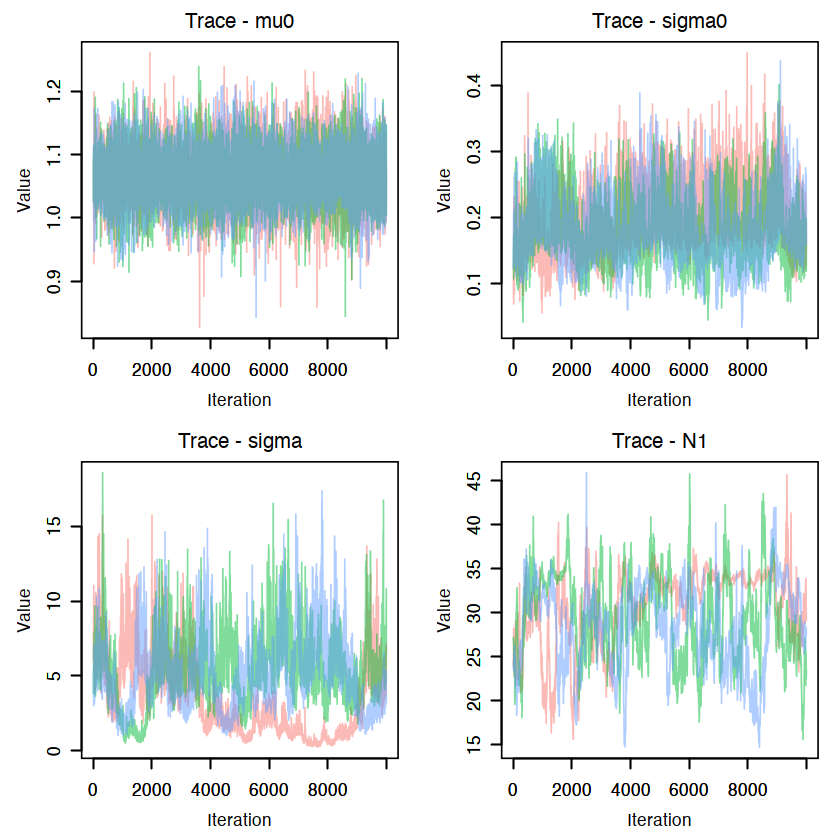

In [12]:
library(MCMCvis)
MCMCtrace(ibexout,                 #the fitted model
          params = ibexparms[1:4], #out parameters of interest
          type="trace",            #plot chain specific density curves
          iter = ni,               #plot all iterations
          pdf = FALSE)             #DON'T write to a PDF

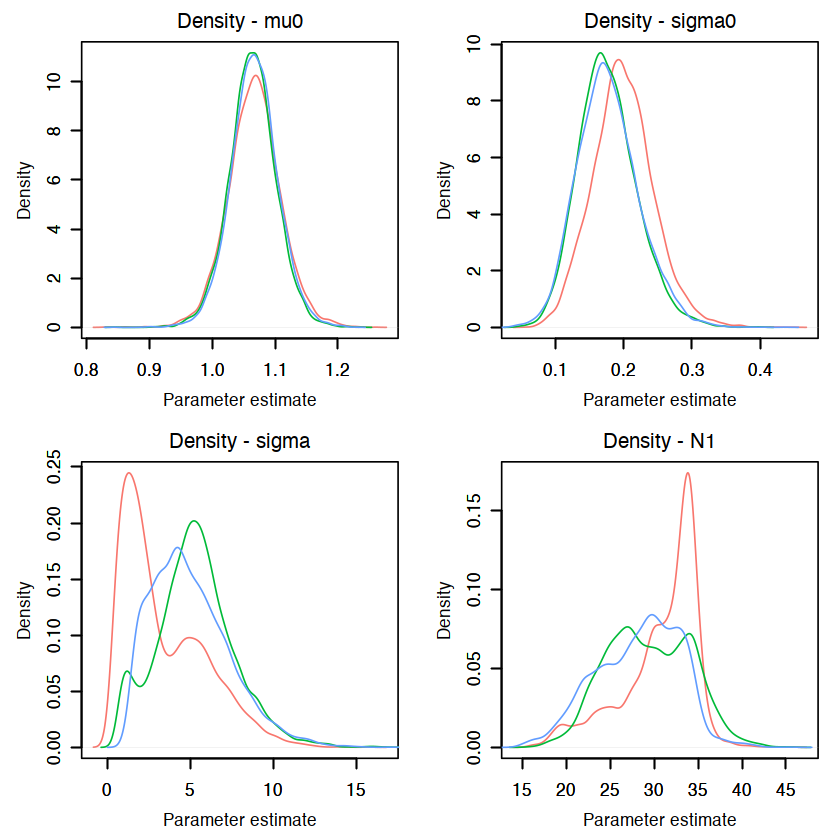

In [13]:
MCMCtrace(ibexout,                 #the fitted model
          params = ibexparms[1:4], #out parameters of interest
          type="density",          #plot chain specific density curves
          iter = ni,               #plot all iterations
          pdf = FALSE,             #DON'T write to a PDF
          ind = TRUE)              #chain specific densities

This passes all the visual tests! Now lets take a look at the R̂  values. These are printed alongside the numeric summaries of the posteriors for each parameter. You can access the summary table by writing the name of the fitted object (ibexout) into the console, but this will spit out everything, including the 30 N’s and 30 λ’s. Instead we can selectively access the summary table using the MCMCvis function MCMCsummary()

In [14]:
MCMCsummary(
    ibexout,                 #the fitted model
    params = ibexparms[1:4], #out parameters of interest
    digits = 3
)

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mu0,1.070,0.0394,0.989,1.070,1.150,1.00,1580
sigma0,0.184,0.0459,0.102,0.182,0.281,1.06,40
sigma,4.580,2.5400,0.664,4.490,10.100,1.14,20
N1,29.500,4.7300,19.600,30.100,37.000,1.05,43


### Posterior inference
Lets take a second to discuss the important parts of the JAGS. Parameter specific chains, i.e, the parameter value at each iteration that makes up the posterior distribution, are contained as names elements of the list object called sims.list. So, as an example, we can do the following:

In [15]:
#access the posterior of each parameter
mu0 <- ibexout$sims.list$mu0
sigma0 <- ibexout$sims.list$sigma0
sigma <- ibexout$sims.list$sigma

These area all vectors because the parameters are scalars. The N’s and $\lambda$’s on the other hand are indexed by time, so using the same code as above will extract matrices, not vectors, with a row per iteration and a column per time. Note also that the λ’s are transition rates describing how abundance changes from one time period to the next, so there will be t−1 columns.

In [16]:
Nhat <- ibexout$sims.list$N
lambda <- ibexout$sims.list$lambda
dim(Nhat)

[1] 30000    25

In [17]:
lambda_df <- data.frame(
    Year = 1:(years-1),
    Mean = ibexout$mean$lambda,
    Lower = ibexout$q2.5$lambda,
    Upper = ibexout$q97.5$lambda,
    MU = ibexout$mean$mu0
)

In [18]:
require(cowplot)

Loading required package: cowplot

Warning message:
“package ‘cowplot’ was built under R version 4.1.1”


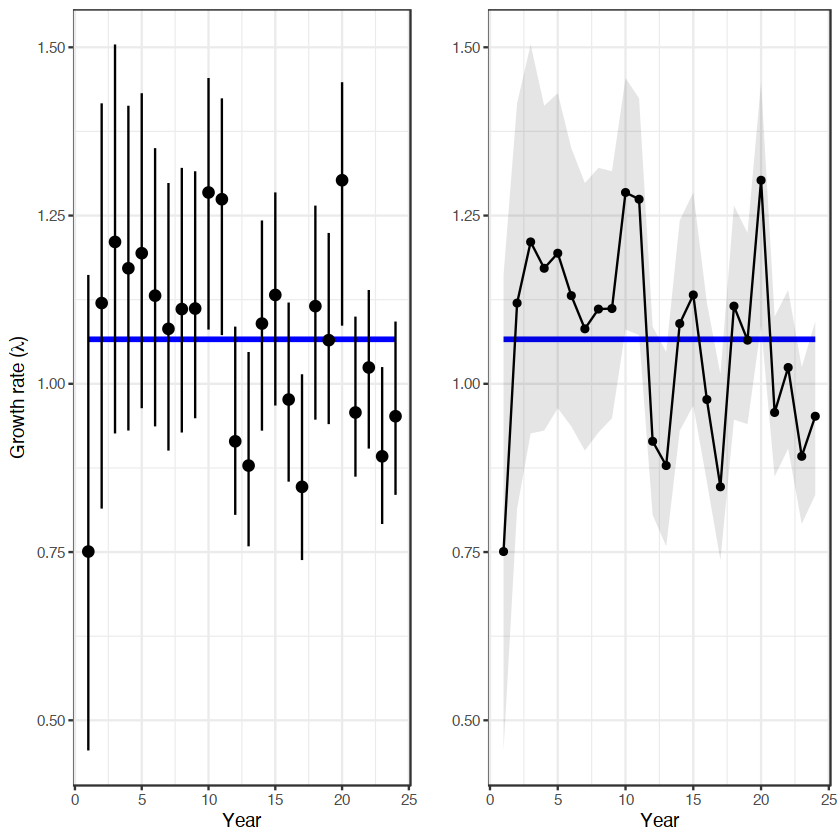

In [19]:
gbars <- ggplot(data=lambda_df) +
          geom_line(aes(x=Year, y=MU), color="blue", size=1.2) +
          geom_errorbar(aes(x=Year, y=Mean, ymin=Lower, ymax = Upper, width=0)) + 
          geom_point(aes(x=Year, y=Mean), size=2.5) + 
          ylab(expression(paste("Growth rate (",lambda,")"))) + theme_bw()

gribn <- ggplot(data=lambda_df) +
          geom_line(aes(x=Year, y=MU), color="blue", size=1.2) +
          geom_ribbon(aes(x=Year, y=Mean, ymin=Lower, ymax = Upper), 
                      fill="black", alpha=0.1) + 
          geom_line(aes(x=Year, y=Mean)) + 
          geom_point(aes(x=Year, y=Mean)) + 
          ylab("") + theme_bw()
cowplot::plot_grid(gbars,gribn,nrow=1)

What are the estimates means and 95% Bayesian Credible Intervals for $\mu_{\lambda}$, $\sigma_{\lambda}$, $\sigma_{y}$ and $N_{1}$.

In [20]:
mu0 <- data.frame(
    Mean = ibexout$mean$mu0,
    Lower = ibexout$q2.5$mu0,
    Upper = ibexout$q97.5$mu0 
)
mu0

sigma0 <- data.frame(
    Mean = ibexout$mean$mu0,
    Lower = ibexout$q2.5$mu0,
    Upper = ibexout$q97.5$mu0 
)
sigma0 <- data.frame(
    Mean = ibexout$mean$sigma0,
    Lower = ibexout$q2.5$sigma0,
    Upper = ibexout$q97.5$sigma0 
)
sigma0
sigma <- data.frame(
    Mean = ibexout$mean$sigma,
    Lower = ibexout$q2.5$sigma,
    Upper = ibexout$q97.5$sigma 
)
sigma

n1 <- data.frame(
    Mean = ibexout$mean$N1,
    Lower = ibexout$q2.5$N1,
    Upper = ibexout$q97.5$N1 
)
n1

Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
1.066131,0.9891799,1.145286


Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
0.1841257,0.1020926,0.2812978


Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
4.583423,0.6636083,10.06902


Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
29.48834,19.55903,37.02278


In [26]:
Nout <- data.frame(
    Year = 1:(years),
    Mean = ibexout$mean$N,
    Lower = ibexout$q2.5$N,
    Upper = ibexout$q97.5$N,
    observation_line = ibexout$mean$y
)

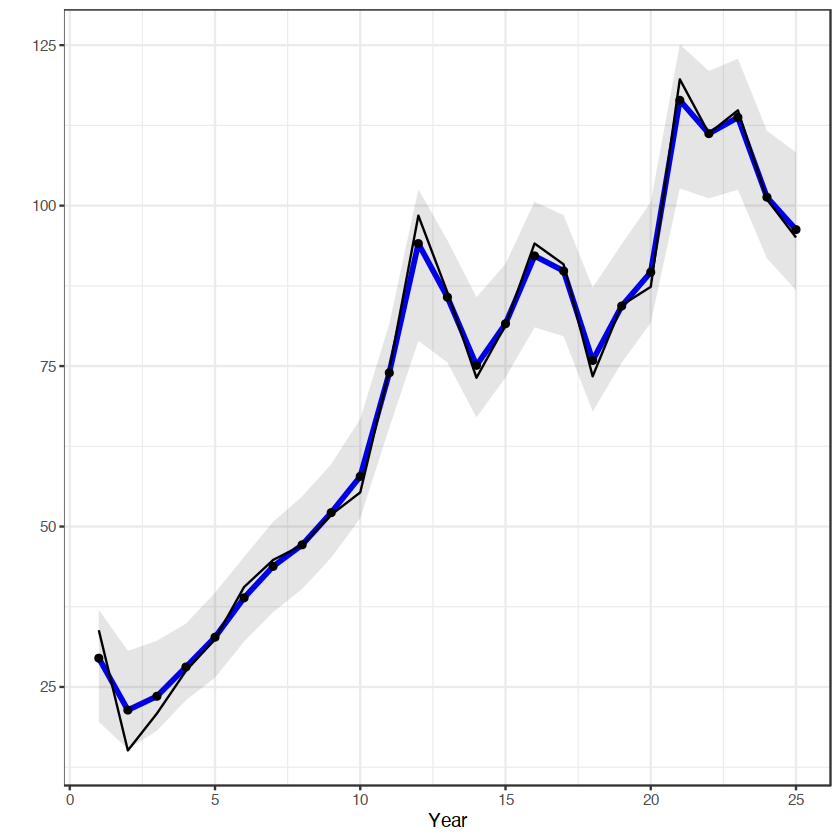

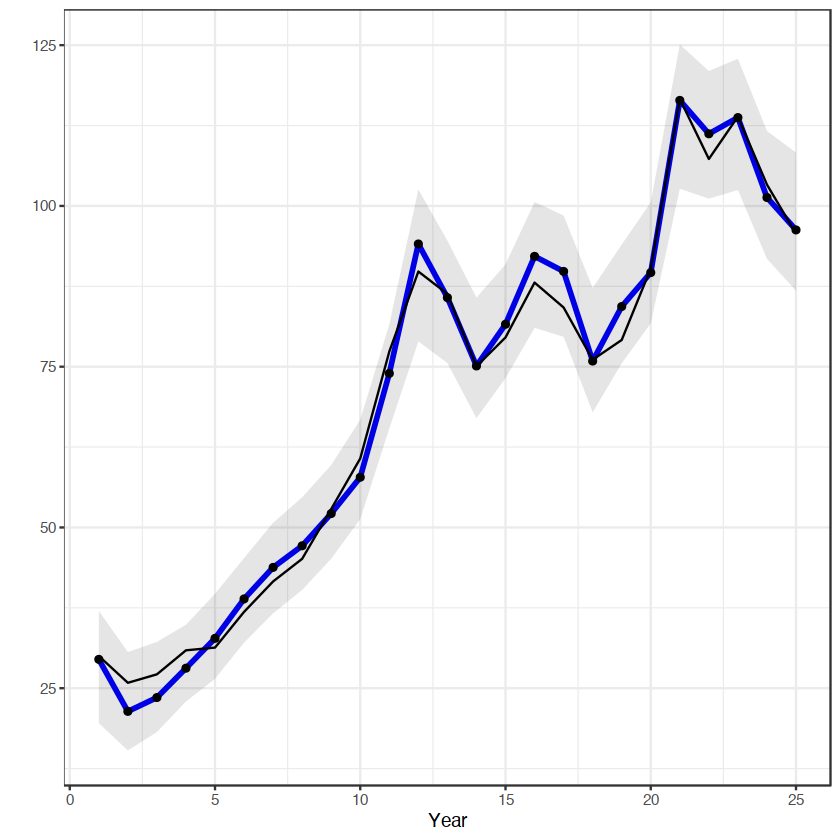

In [29]:
ggplot(data=Nout) +
          geom_line(aes(x=Year, y=Mean), color="blue", size=1.2) +
          geom_ribbon(aes(x=Year, y=Mean, ymin=Lower, ymax = Upper), 
                      fill="black", alpha=0.1) + 
          geom_line(aes(x=Year, y=observation_line)) + 
          geom_point(aes(x=Year, y=Mean)) + 
          ylab("") + theme_bw()

ggplot(data=Nout) +
          geom_line(aes(x=Year, y=Mean), color="blue", size=1.2) +
          geom_ribbon(aes(x=Year, y=Mean, ymin=Lower, ymax = Upper), 
                      fill="black", alpha=0.1) + 
          geom_line(aes(x=Year, y=N)) + 
          geom_point(aes(x=Year, y=Mean)) + 
          ylab("") + theme_bw()